## Sign Language Detection using Resnet 50

### Import Libraries 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras.models import Model
from keras.preprocessing import image
%matplotlib inline
import os
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import classification_report
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
from tensorflow.python.keras.layers import Input, Dense, Flatten, Lambda, Dropout

In [4]:
import pathlib
data_dir = "ISL-Original/Training"
data_dir = pathlib.Path(data_dir)

###  Image Data Augmentation

We have implemented Image Augmentation using ImageDataGenerator - an augmented image generator API in Keras. It generates batches of image data with real-time data augmentation. For practical applications we have applied rotation, height/weight shift, zoom, flip and brightness high/low to our training dataset.

In [5]:
# ImageDataGenerator
datagen = ImageDataGenerator(
    validation_split=0.2,
         rotation_range=10, # rotation
         width_shift_range=0.2, # horizontal shift
         height_shift_range=0.2, # vertical shift
         zoom_range=0.2, # zoom
         horizontal_flip=True, # horizontal flip
         brightness_range=[0.2,1.2]) # brightness

test_datagen=ImageDataGenerator(validation_split=0.2)
train_ds = datagen.flow_from_directory(data_dir,
                                           class_mode = 'categorical',
                                           target_size = (180, 180),
                                           batch_size=32,
                                       subset='training',
                                           seed=46)
val_ds = test_datagen.flow_from_directory(data_dir,
                                     class_mode = 'categorical',
                                     target_size = (180, 180),
                                     batch_size=32,
                                          subset='validation',
                                     seed=46)

Found 8803 images belonging to 26 classes.
Found 2189 images belonging to 26 classes.


### Declare Metrics 

Metrics have been removed from Keras core. We need to calculate them manually.

In [13]:
from tensorflow.keras import backend as K
def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    precision_f = precision(y_true, y_pred)
    recall_f = recall(y_true, y_pred)
    return 2*((precision_f*recall_f)/(precision_f+recall_f+K.epsilon()))

### Implement the Deep Learning Model - Resnet50

ResNet-50 is a convolutional neural network that is 50 layers deep. We can load a pretrained version of the network trained on more than a million images from the ImageNet database.

In [7]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=35,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [8]:
# Fully Connected Layer
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(26, activation='softmax'))

In [9]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 2048)              0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 512)               1049088   
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 26)                13338     
Total params: 24,650,138
Trainable params: 1,062,426
Non-trainable params: 23,587,712
_________________________________________________________________


In [14]:
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy', metrics = ['accuracy',f1, precision,recall])

history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
276/276 [==============================] - 1018s 4s/step - loss: 0.3631 - accuracy: 0.9024 - f1: 0.8918 - precision: 0.9454 - recall: 0.8658 - val_loss: 0.1032 - val_accuracy: 0.9730 - val_f1: 0.9721 - val_precision: 0.9745 - val_recall: 0.9697
Epoch 2/5
276/276 [==============================] - 925s 3s/step - loss: 0.1035 - accuracy: 0.9667 - f1: 0.9663 - precision: 0.9710 - recall: 0.9618 - val_loss: 0.1545 - val_accuracy: 0.9497 - val_f1: 0.9496 - val_precision: 0.9512 - val_recall: 0.9482
Epoch 3/5
276/276 [==============================] - 710s 3s/step - loss: 0.0733 - accuracy: 0.9793 - f1: 0.9784 - precision: 0.9808 - recall: 0.9761 - val_loss: 0.0465 - val_accuracy: 0.9836 - val_f1: 0.9837 - val_precision: 0.9841 - val_recall: 0.9832
Epoch 4/5
276/276 [==============================] - 742s 3s/step - loss: 0.0631 - accuracy: 0.9802 - f1: 0.9802 - precision: 0.9824 - recall: 0.9781 - val_loss: 0.1014 - val_accuracy: 0.9762 - val_f1: 0.9757 - val_precision: 0.9768 - va

### Learning Curves - Graphs

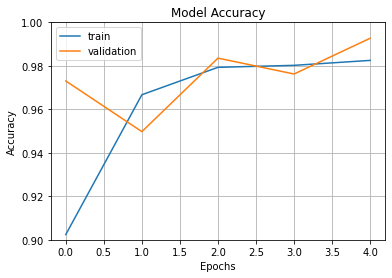

In [18]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.9,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

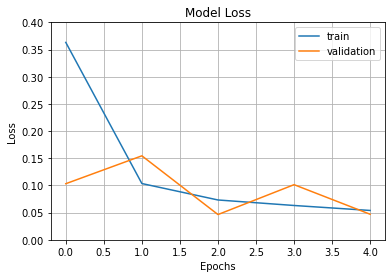

In [27]:
fig1 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=0.4)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

### Predict Images 

['B']

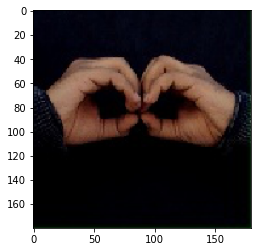

In [20]:
#Creating a dictionary to map each of the indexes to the corresponding number or letter
from keras.preprocessing import image
dict = {0:"A",1:"B",2:"C",3:"D",4:"E",5:"F",6:"G",7:"H",8:"I",9:"J",10:"K",
        11:"L",12:"M",13:"N",14:"O",15:"P",16:"Q",17:"R",18:"S",19:"T",20:"U",21:"V",22:"W",23:"X",
        24:"Y",25:"Z"}


#Predicting images

img = image.load_img("sign_B2.jpg", target_size=(180, 180))
x = image.img_to_array(img)
plt.imshow(img)
x = np.expand_dims(x, axis=0)

image = np.vstack([x])
classes = resnet_model.predict(image, batch_size=64)
label = [np.argmax(i) for i in classes]
pred_class=[dict[x] for x in label]
pred_class

### Evaluating the Model 

_Plotting the Confusion Matrix_


In [21]:
Y_pred = resnet_model.predict_generator(val_ds)
y_pred = np.argmax(Y_pred, axis=1)

Text(0.5, 33.0, 'Predicted label')

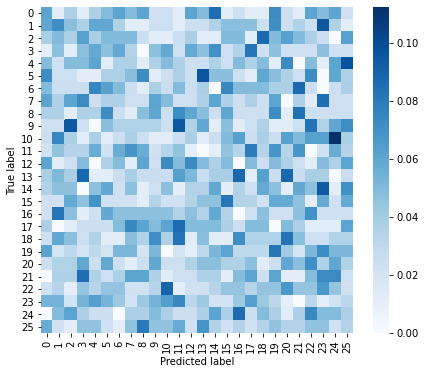

In [22]:
cf_mat = confusion_matrix(val_ds.classes, y_pred)
cf_mat_normalized = cf_mat.astype('float') / cf_mat.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(7, 6))
sns.heatmap(cf_mat_normalized, cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')

_Printing the Classification Report_

In [23]:
labels = val_ds.classes

In [24]:
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

           0       0.06      0.06      0.06        82
           1       0.07      0.07      0.07        84
           2       0.04      0.04      0.04        80
           3       0.05      0.05      0.05        85
           4       0.06      0.06      0.06        82
           5       0.04      0.04      0.04        83
           6       0.05      0.05      0.05        80
           7       0.02      0.02      0.02        82
           8       0.05      0.05      0.05        83
           9       0.04      0.04      0.04        84
          10       0.01      0.01      0.01        80
          11       0.05      0.05      0.05        88
          12       0.08      0.07      0.08        82
          13       0.02      0.03      0.02        79
          14       0.06      0.06      0.06        85
          15       0.08      0.08      0.08        86
          16       0.00      0.00      0.00        85
          17       0.05    

_Evalutation Metrics on Test Set_

In [25]:
loss, accuracy, f1_score, precision, recall = resnet_model.evaluate(val_ds, verbose=0)

In [29]:
print(f"Test Loss: ", round(loss*100, 3), '%')
print(f"Test Accuracy: ", round(accuracy*100, 3), '%')
print(f"Test Precision: ", round(precision*100, 3), '%')
print(f"Test Recall: ",round(recall*100, 3), '%')
print(f"Test F1 Score: ",round(f1_score*100, 3), '%')

Test Loss:  4.699 %
Test Accuracy:  99.269 %
Test Precision:  99.411 %
Test Recall:  99.275 %
Test F1 Score:  99.342 %
